In [1]:
from datetime import date, timedelta, datetime
from dateutil.parser import parse
from typing import Sequence
from pathlib import Path
import sh 
from PIL import Image
# import cv2

import matplotlib.pyplot as plt
import pandas as pd
import geomagdata as gi
import numpy as np
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
def format_func(x, 
                pos=None
               ):
    x = mdates.num2date(x)
    
    if x.day == 15 and x.hour == 15:
        fmt = '%H\n%y/%m/%d'
    elif x.hour == 15:
        fmt = '%H\n%m/%d'
    else:
        fmt = '%H'
    label = x.strftime(fmt)
    
    
    return label

In [3]:
def getAEindex_daily(date = datetime(2022, 8, 31),
                     AEdir = Path(f'/run/media/echoo/TOSHIBA EXT/space_weather/AEindex/')
                    ):
    yyyymm = date.strftime('%Y%m')
    yyyymmdd = date.strftime('%Y%m%d')

    # https://wdc.kugi.kyoto-u.ac.jp/ae_realtime/index.html
    webpage = Path(f'https://wdc.kugi.kyoto-u.ac.jp/ae_realtime')
    AEonline = webpage/f'{yyyymm}'/f'rtae_{yyyymmdd}.png'
    AEfile = AEdir/f'rtae_{yyyymmdd}.png'
    
    if Path.is_file(AEfile):
        pass
    else:
        sh.touch(AEfile)
        sh.curl('-o', AEfile, AEonline)

    AEimage = Image.open(AEfile)
#     AEimage
    
    pixels = np.array(AEimage)[::-1]
    vspan = range(82, 196)
    hspan = range(80, 650)
    rpixel = 0
    wpixel = 255
    graypixel = 187
    
    scale = 2000/len(vspan)       # units: nT
    
    AEpixels = pixels[vspan][:,hspan][:,:,rpixel]

#     AEpixels = np.where(AEpixels == wpixel   , np.NaN, AEpixels)
#     AEpixels = np.where(AEpixels == graypixel, np.NaN, AEpixels)
#     plt.contour(AEpixels)
#     AEpixels.shape
    
    AEpixels = np.where(AEpixels == wpixel, 
                        None, 
                        AEpixels
                       )
    AEpixels = np.where(AEpixels == graypixel, 
                        None, 
                        AEpixels
                       )
    
    tlength = AEpixels.shape[1]
    AEedge = np.zeros(tlength)
#     AEedge.shape
    for  t, plh in enumerate(AEpixels[0][:]):
        for v, plv in enumerate(AEpixels[::-1, t]):
            if plv is not None :
                AEedge[t] = (len(vspan)-v) * scale
    #             print(h, AE[h])
                break
            AEedge[t] = np.NaN
            continue
    
    AEedge = np.where(AEedge > 1500, np.NaN, AEedge)
#     plt.plot(AEedge)
#     plt.ylim(0,2000)


    start = date
    end   = start + timedelta(days = 1)
    tspan = pd.date_range(start = start, 
                          periods = 1440, 
                          freq = 'T'         # frequency: 1 min
                         )    

    tseq = np.arange( len(tspan) ) * len(hspan) / len(tspan)    # for interp
    AE_interp = np.interp(tseq, 
                          np.arange(tlength), 
                          AEedge, 
                          left = True, 
                          right = True
                         )

    data = {'time':tspan,
            'AE'  :AE_interp
           }
    AEdframe = pd.DataFrame(data)
    AEdframe['AE'] = AEdframe['AE'].interpolate()
    return AEdframe

# AE = getAEindex_daily(datetime(2022,8,27), AEdir)

In [4]:
def plotF107(ax, indices):
#     ticks = [0, 12]
#     ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
#     # ax.xaxis.set_minor_locator(mdates.Locator())
#     ax.xaxis.set_major_formatter(format_func)
    ax.set_xticks([])

    colors     = ['xkcd:pastel pink', 'xkcd:pinkish red']
    thresholds = [120]
    control    = [0] + thresholds + [1000]
    thresholds_spans = [i for i in zip(control, control[1:])]
    dates = indices.index
    
#     ax.set_xlim(dates[0], dates[-1])
    ax.set_ylim(90, 240)
    ax.set_yticks(np.arange(90, 270, 30))

    for color , thresholds_span in zip(colors, thresholds_spans):
        low, high = thresholds_span
        line_data = np.ma.masked_array(indices['f107s'].values, 
                                       mask = (indices['f107s'].values<low)|(indices['f107s'].values>high)
                                      )
        ax.plot(dates, 
                line_data, 
                color, 
                marker='.', 
                markersize = 3.5,
                linewidth = 0
               )

    for threshold in thresholds:
        ax.axhline(threshold,
                   linestyle = '--',
                   color = 'grey',
                   alpha = 0.3,
                   zorder = -100
                  )
        
#     ax.set_ylabel("F10.7 (sfu)")
    ax.set_title("a) F10.7 (sfu)", 
                 loc = 'left'
                )
#     ax.set_xlabel("time (LT)")
    # ax.grid(True)

    # fig.savefig('2015.png', bbox_inches='tight')

#     plt.show()

In [5]:
help(plt.title)

Help on function title in module matplotlib.pyplot:

title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)
    Set a title for the Axes.
    
    Set one of the three available Axes titles. The available titles
    are positioned above the Axes in the center, flush with the left
    edge, and flush with the right edge.
    
    Parameters
    ----------
    label : str
        Text to use for the title
    
    fontdict : dict
        A dictionary controlling the appearance of the title text,
        the default *fontdict* is::
    
           {'fontsize': rcParams['axes.titlesize'],
            'fontweight': rcParams['axes.titleweight'],
            'color': rcParams['axes.titlecolor'],
            'verticalalignment': 'baseline',
            'horizontalalignment': loc}
    
    loc : {'center', 'left', 'right'}, default: :rc:`axes.titlelocation`
        Which title to set.
    
    y : float, default: :rc:`axes.titley`
        Vertical Axes location for the title (1.0 

In [6]:
def plotAE(ax, AEindex):
#     ticks = [0,12]
#     ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
#     # ax.xaxis.set_minor_locator(mdates.Locator())
#     ax.xaxis.set_major_formatter(format_func)
    ax.set_xticks([])

    colors = ['mistyrose', 'crimson']
    thresholds = [500]
    control    = [0] + thresholds + [2000]
    thresholds_spans = [i for i in zip(control, control[1:])]
    
    ax.set_ylim(0,1500)
    ax.set_yticks(np.arange(0,2000,500))

    for color , thresholds_span in zip(colors, thresholds_spans):
        low, high = thresholds_span
        AEplt     = AEindex['AE'].values
        tplt      = AEindex['time']
        line_data = np.ma.masked_array(AEplt, 
                                       mask = (AEplt<low)|(AEplt>high)
                                      )
        ax.plot(tplt, 
                 line_data, 
                 color, 
                 marker = ',',
    #              linewidth = 1
                )

    for threshold in thresholds:
        ax.axhline(threshold,
                    linestyle = '--',
                    color = 'grey',
                    alpha = 0.3,
                    zorder = -100
                  )
#     ax.set_ylabel("AE index (nT)")
    ax.set_title("b) AE index (nT)", loc = 'left')
#     ax.set_xlabel("time (LT)")
    # ax.grid(True)

    # fig.savefig('2015.png', bbox_inches='tight')

#     plt.show()


In [7]:
def plotKp(ax, indices):
    dates = indices.index
    
    ticks = np.arange(0,27,3)
    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    # ax.xaxis.set_minor_locator(mdates.Locator())
    ax.xaxis.set_major_formatter(format_func)
    # inds['Ap'].plot(ax=ax)
    
    ax.set_ylim(0, 9)
    ax.set_yticks(np.arange(1,10,2))
    ax.bar(dates, 
            indices['Kp'].values, 
            width = 0.1, 
            color = np.where(indices['Kp']>3, 
                             'red', 
                             'lavenderblush'
                            )
    #         color = np.where(indices['Kp']>3, 'royalblue', 'aliceblue'),
    #         edgecolor = 'aliceblue',
    #         color = 'dodgerblue'
           )
    # indices['Kp'].plot(ax = ax, marker = '.')  # , marker='.'
    ax.axhline(3,
               linestyle = '--',
               color = 'grey',
               alpha = 0.3,
               zorder = -100
              )
#     ax.set_ylabel("Kp index")
    ax.set_title("c) Kp index", loc = 'left')
    ax.set_xlabel("time (LT)")
    # ax.grid(True)

    # fig.savefig('2015.png', bbox_inches='tight')

#     plt.show()

In [8]:
# start = datetime(2022, 8, 22)
# end   = datetime(2022, 8, 29)
# timezone = 8
start = datetime(2022, 1, 15)
end   = datetime(2022, 1, 17)
timezone = 15
dates = pd.date_range(start, end, freq="3H")

try:
    indices = gi.get_indices(dates, smoothdays = 3)
except ConnectionError as e:
    pytest.skip(f"possible timeout error {e}")

pasttime = datetime(2017, 1, 1)
if indices["resolution"][0] == "d":
    pasttime += timedelta(hours=1, minutes=30)

indices.index += timedelta(hours = timezone)

In [9]:
AEdir = Path(f'/run/media/echoo/TOSHIBA EXT/space_weather/AEindex/')

is_first_day = True
for date in pd.date_range(start, 
                          end-timedelta(days=1),
                          freq = '1D'
                         ):
    AE = getAEindex_daily(date, AEdir)
#     plt.ylim(0,2000)
#     plt.plot(AE['AE'])
    if is_first_day:
        AEindex = AE
    else:
        AEindex = pd.concat([AEindex, AE], 
                            axis = 0 
                           )
    is_first_day = False

AEindex['time'] += timedelta(hours = timezone) 

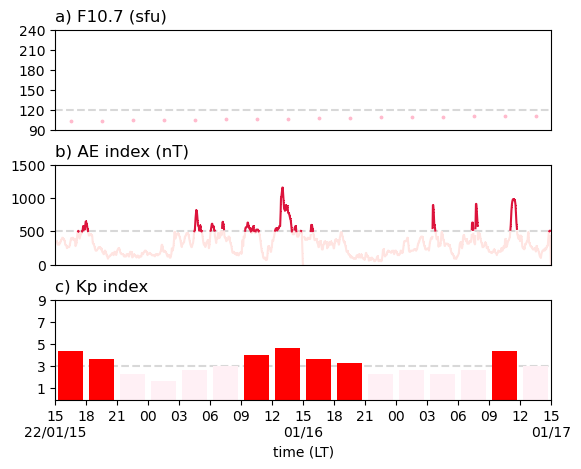

In [10]:
fig, ax = plt.subplots(3, 1)
fig.subplots_adjust(hspace = 0.35)

xstart = AEindex['time'].values[0]
xend   = AEindex['time'].values[-1] + np.timedelta64(1, 'm')
plotF107(ax[0], 
         indices
        )
ax[0].set_xlim(xstart, xend)

plotAE(ax[1], 
       AEindex
      )
ax[1].set_xlim(xstart, xend)

plotKp(ax[2], 
       indices
      )
ax[2].set_xlim(xstart, xend)

fig.align_ylabels()